In [1]:
#Take the raw abc notation musical data, and normalize all tunes to the same base key

In [1]:
import numpy as np
import contextlib
import io
from music21 import converter, pitch as m21pitch, interval, key as m21key
import re

def clean_abc(abc):
    # Remove standalone J decorations (like JA, JB, J{A/}, etc.). music21 assumes these are notes, not decorations
    return re.sub(r'J[\w{/}]*', '', abc)


def transpose_to_tonic(stream, mode_str, target_tonic='D'):
    """
    Transpose the music21 stream so that its tonic becomes the given target_tonic.
    mode_str is a string like 'Amixolydian' or 'Dminor'.
    """
    known_modes = ["major", "minor", "dorian", "mixolydian"]
    try:
        mode_str = mode_str.lower().strip()
        for mode in known_modes:
            if mode_str.endswith(mode):
                tonic = mode_str[:-len(mode)]
                user_key = m21key.Key(tonic.capitalize(), mode)
                tonic_note = m21pitch.Pitch(user_key.tonic.name)
                target_note = m21pitch.Pitch(target_tonic)
                i = interval.Interval(tonic_note, target_note)
                return stream.transpose(i)
        # fallback if mode not matched
        print(f"Unknown mode in mode_str={mode_str}")
        return stream
    except Exception as e:
        print(f"Could not transpose due to error: {e} in mode_str={mode_str}")
        return stream


def get_key_normalized_pitch_vector(abc, meter='4/4', mode='Cmajor', target_tonic='D', idx=None):
    try:
        abc = clean_abc(abc)
        abc_full = f"""X:1\nT:Tune\nM:{meter}\nK:{mode}\n{abc}"""
        with contextlib.redirect_stdout(io.StringIO()):
            s = converter.parse(abc_full, format='abc')
        s = transpose_to_tonic(s, mode, target_tonic)
        notes = s.flat.notes.stream()
        midi_pitches = [n.pitch.midi for n in notes if n.isNote]

        pitch_vector = np.zeros(36)
        for midi in midi_pitches:
            if 48 <= midi <= 83:
                pitch_vector[midi - 48] += 1

        if pitch_vector.sum() > 0:
            pitch_vector /= pitch_vector.sum()
        return pitch_vector
    except Exception as e:
        print(f"[Row {idx}] Error: {e} | mode={mode} | meter={meter}")
        return np.zeros(36)



In [69]:
#Apply key normalization to entire data set

In [98]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load your parsed tune DataFrame
df_whole = pd.read_csv("../data/processed/parsed_tunes.csv")

#df = df_whole.copy()
def has_key_change_robust(abc):
    return bool(re.search(r'\[K\s*:[^\]]+\]', abc, re.IGNORECASE))

# Filter out tunes with internal key changes
df_clean = df_whole[~df_whole["abc"].apply(has_key_change_robust)].copy()
#df = df_clean.sample(2000, random_state=42).reset_index(drop=True)
df = df_clean.copy()

#print("Before:", len(df_whole))
#print("After:", len(df_clean))
#print("Removed:", len(df_whole) - len(df_clean))

# Extract clean mode types
known_modes = ["major", "minor", "dorian", "mixolydian"]

def extract_mode_type(mode_str):
    if not isinstance(mode_str, str):
        return None
    mode_str = mode_str.lower().strip()
    for mode in known_modes:
        if mode_str.endswith(mode):
            return mode
    return None

df["mode_type"] = df["mode"].apply(extract_mode_type)
df = df[df["mode_type"].notnull()].copy()

# Compute key-normalized pitch histograms for all tunes
tqdm.pandas(desc="Key-normalizing pitch vectors (debug mode)")

df["keynorm_features"] = df.progress_apply(
    lambda row: get_key_normalized_pitch_vector(
        row["abc"], row["meter"], row["mode"], target_tonic="D", idx=row.name
    ),
    axis=1
)
df.to_csv("../data/processed/parsed_tunes_with_keynorm_user_full.csv", index=False)


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

def collapse_to_pitch_classes(pitch_vector_36d):
    """
    Reduce a 36-element pitch histogram to 12-element pitch class histogram.
    Assumes pitch_vector_36d[i] corresponds to MIDI pitch 48 + i (i.e., C3–B5).
    """
    pitch_vector_36d = np.array(pitch_vector_36d)
    pitch_class_vector = np.zeros(12)
    for i in range(len(pitch_vector_36d)):
        pitch_class_vector[i % 12] += pitch_vector_36d[i]
    if pitch_class_vector.sum() > 0:
        pitch_class_vector /= pitch_class_vector.sum()
    return pitch_class_vector

df = pd.read_csv("../data/processed/parsed_tunes_with_keynorm_user_full.csv")

# Fix and parse keynorm_features strings into lists of floats
def parse_vector_string(s):
    # Remove brackets and split by number-like patterns
    return [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", str(s))]

# Apply parsing
df["keynorm_features"] = df["keynorm_features"].apply(parse_vector_string)

df = df[df["keynorm_features"].notnull()].copy()
df = df[df["keynorm_features"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) == 36)]
df["pitchclass_vector"] = df["keynorm_features"].apply(collapse_to_pitch_classes)

# Group by tune name and take the mean pitchclass vector per group
grouped = df.groupby("name")["pitchclass_vector"].apply(
    lambda vectors: np.mean(np.vstack(vectors), axis=0)
)

# Create a new DataFrame from this grouped data
df_unique = pd.DataFrame({
    "name": grouped.index,
    "pitchclass_vector": grouped.values
})

# Also include the most common mode_type for each tune
# (you can choose another strategy if you prefer)
mode_map = df.groupby("name")["mode_type"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
df_unique["mode_type"] = df_unique["name"].map(mode_map)

#df_unique.info()
#duplicate_names = df_unique["name"][df_unique["name"].duplicated()]
#print(f"Number of duplicate names: {duplicate_names.nunique()}")

# Convert to 2D NumPy array
X = np.vstack(df_unique["pitchclass_vector"].values)
y = df_unique["mode_type"].values

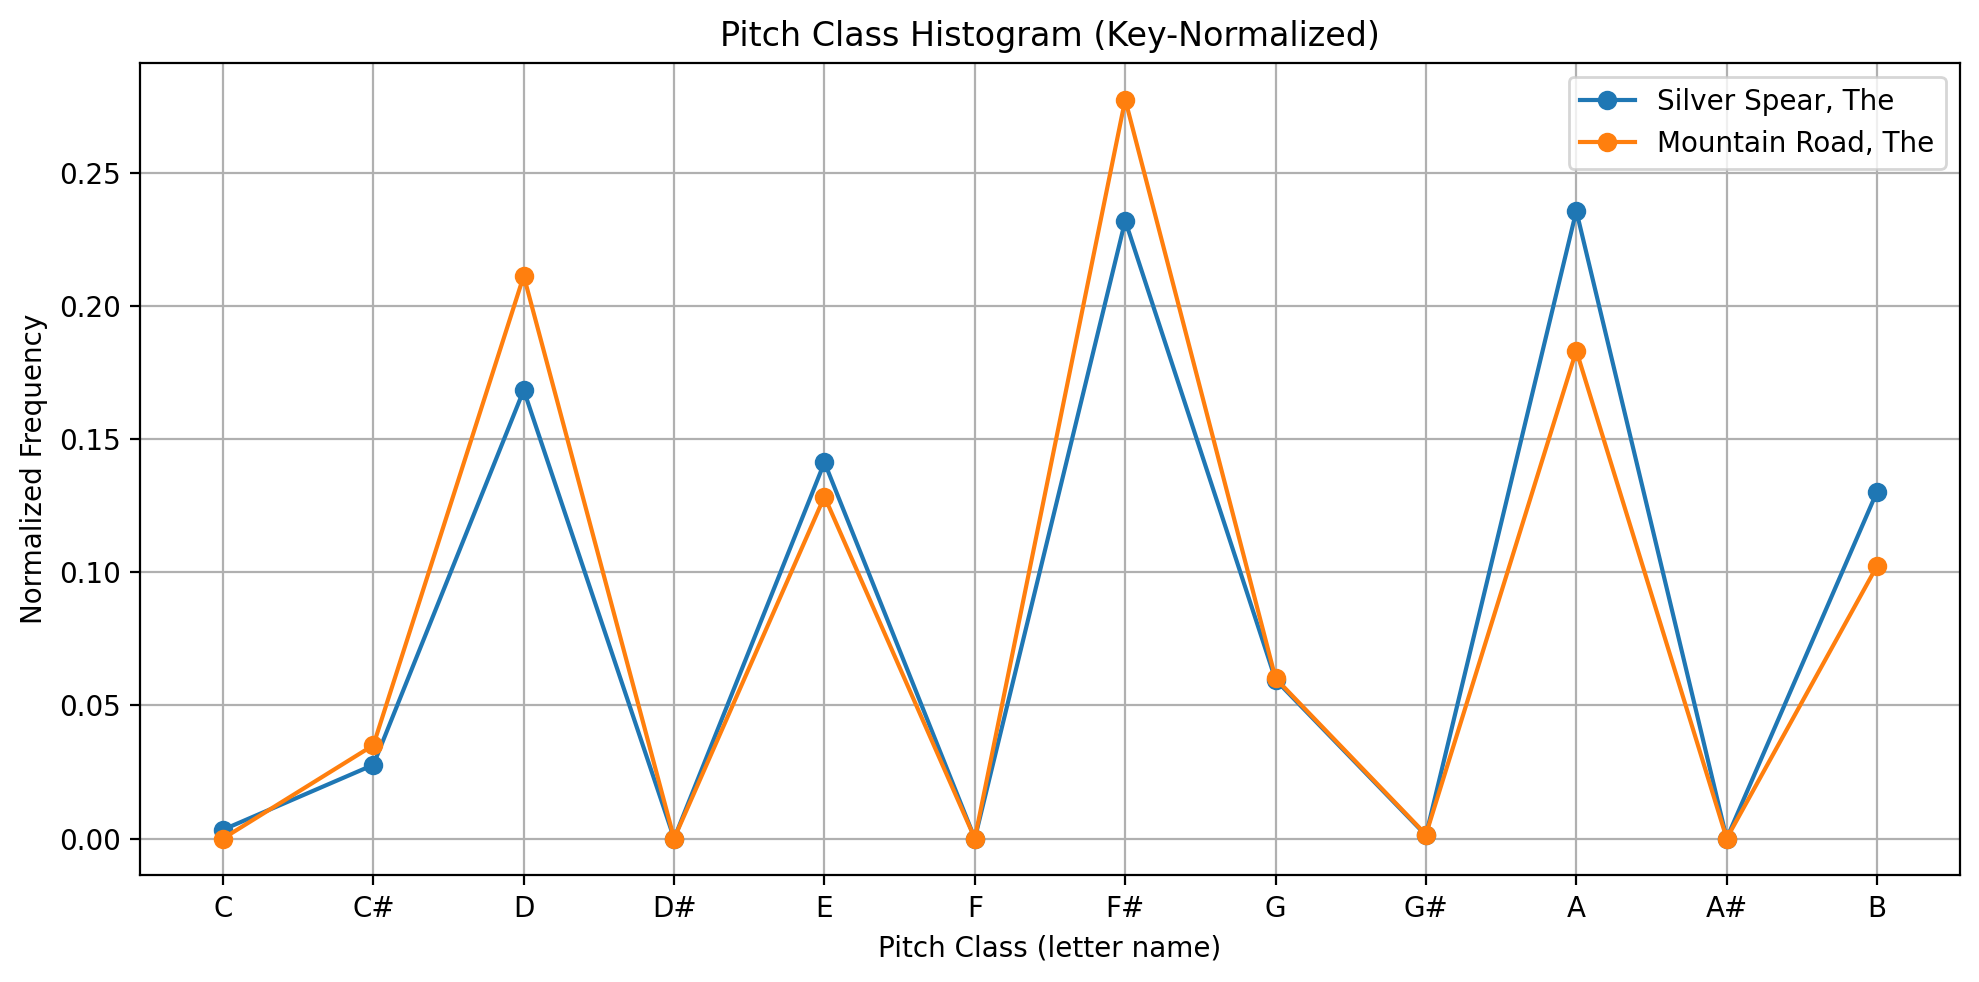

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define pitch class labels starting from C
pitch_class_labels = ['C', 'C#', 'D', 'D#', 'E', 'F',
                      'F#', 'G', 'G#', 'A', 'A#', 'B']

# Select the tunes
tunes_to_plot = ["Silver Spear, The", "Mountain Road, The"]

# Set up the plot
plt.figure(figsize=(10, 5))

for name in tunes_to_plot:
    row = df_unique[df_unique["name"] == name]
    if not row.empty:
        vector = row.iloc[0]["pitchclass_vector"]
        plt.plot(pitch_class_labels, vector, marker='o', label=name)
    else:
        print(f"Tune not found: {name}")

plt.title("Pitch Class Histogram (Key-Normalized)")
plt.xlabel("Pitch Class (letter name)")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


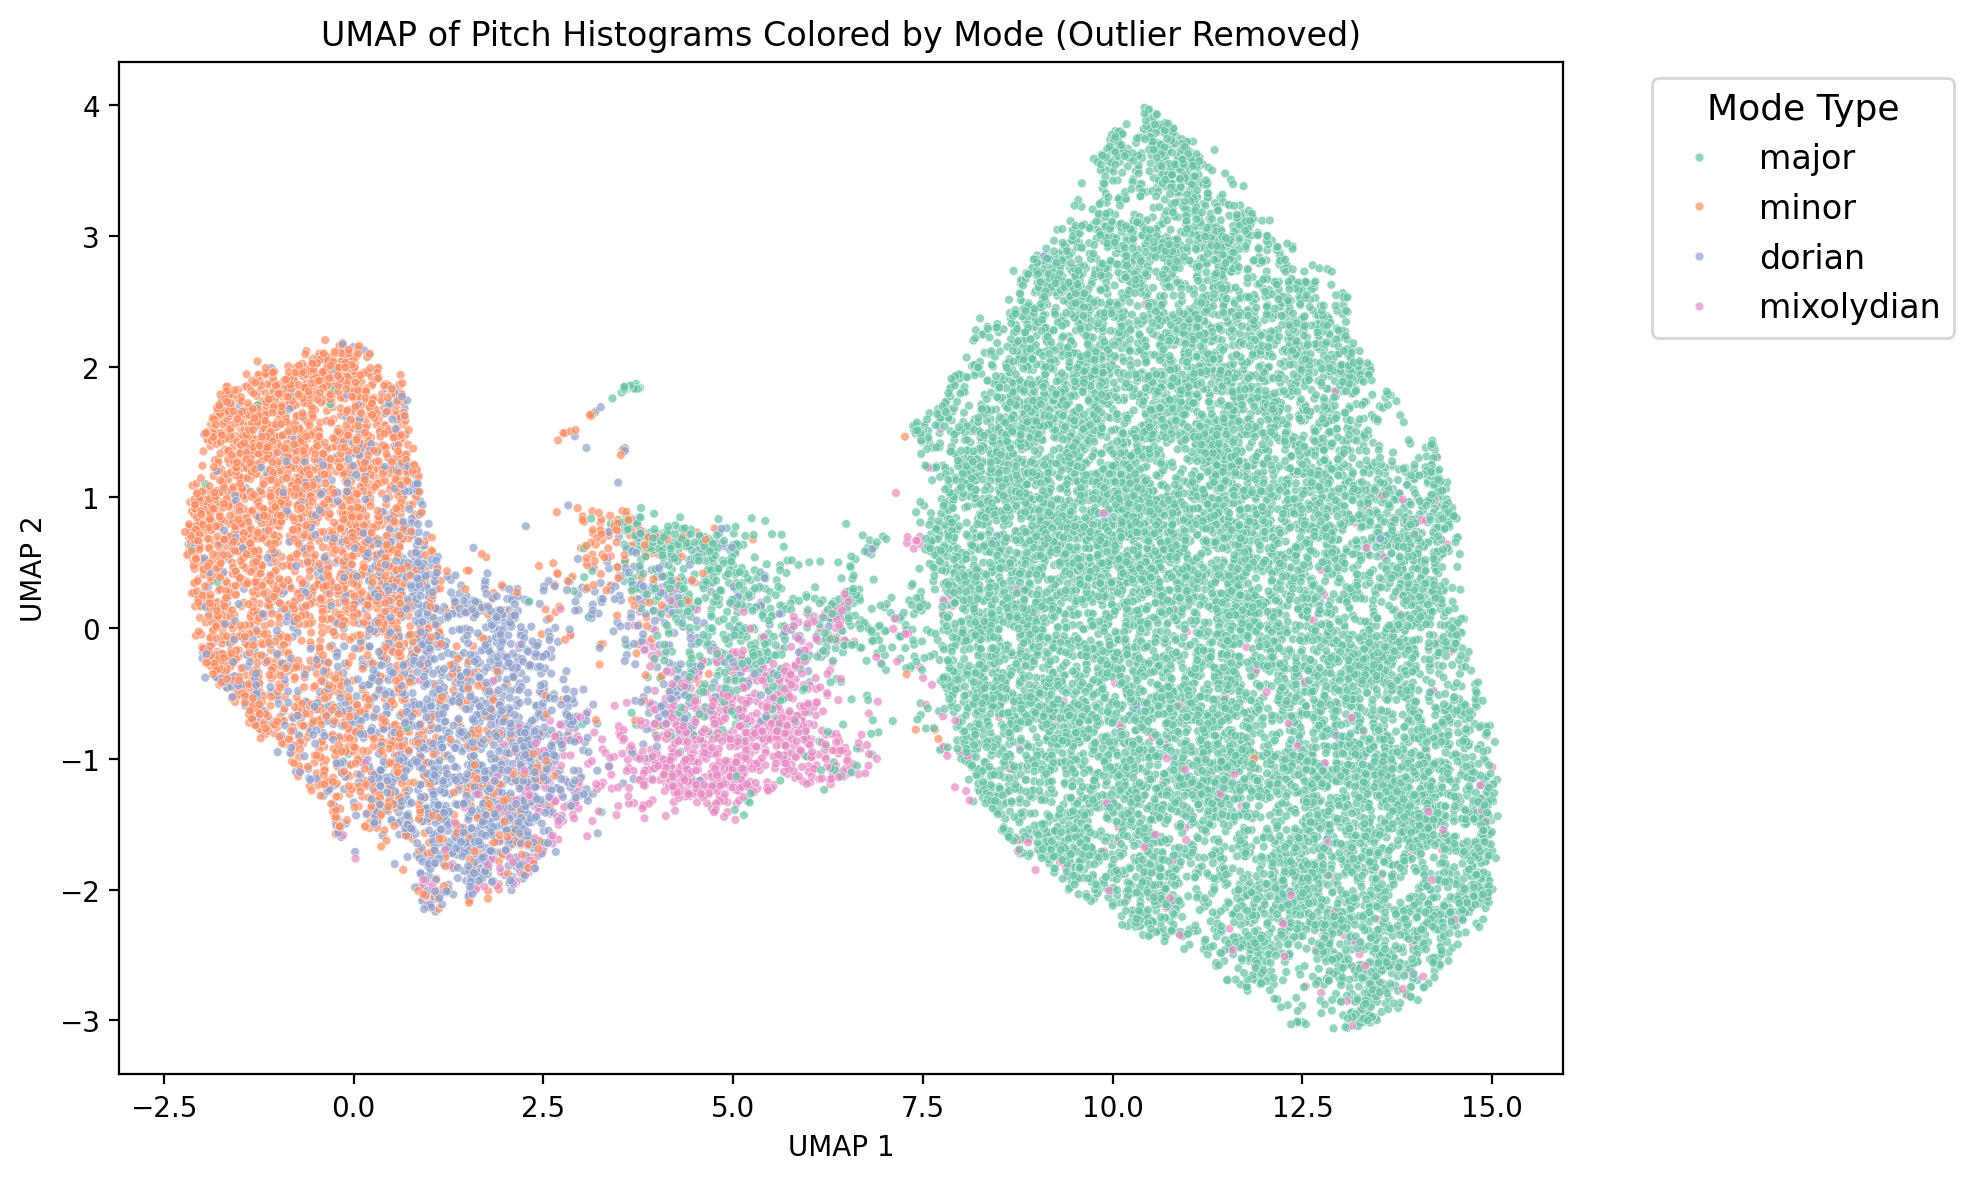

In [11]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
X_umap = umap_model.fit_transform(X)

df_unique["umap1"] = X_umap[:, 0]
df_unique["umap2"] = X_umap[:, 1]
df_plot = df_unique[df_unique["umap2"] < 7].copy()

# Update X_umap and y accordingly
X_umap_filtered = df_plot[["umap1", "umap2"]].values
y_filtered = df_plot["mode_type"].values





plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap_filtered[:, 0], y=X_umap_filtered[:, 1],
                hue=y_filtered, palette="Set2", alpha=0.7, s=10)

plt.title("UMAP of Pitch Histograms Colored by Mode (Outlier Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Mode Type",
    title_fontsize="13",
    fontsize="12",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()


/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


"The Silver Spear" is at UMAP coordinates: x = 12.054, y = -2.493
"Cooleys" is at UMAP coordinates: x = 2.189, y = -0.422


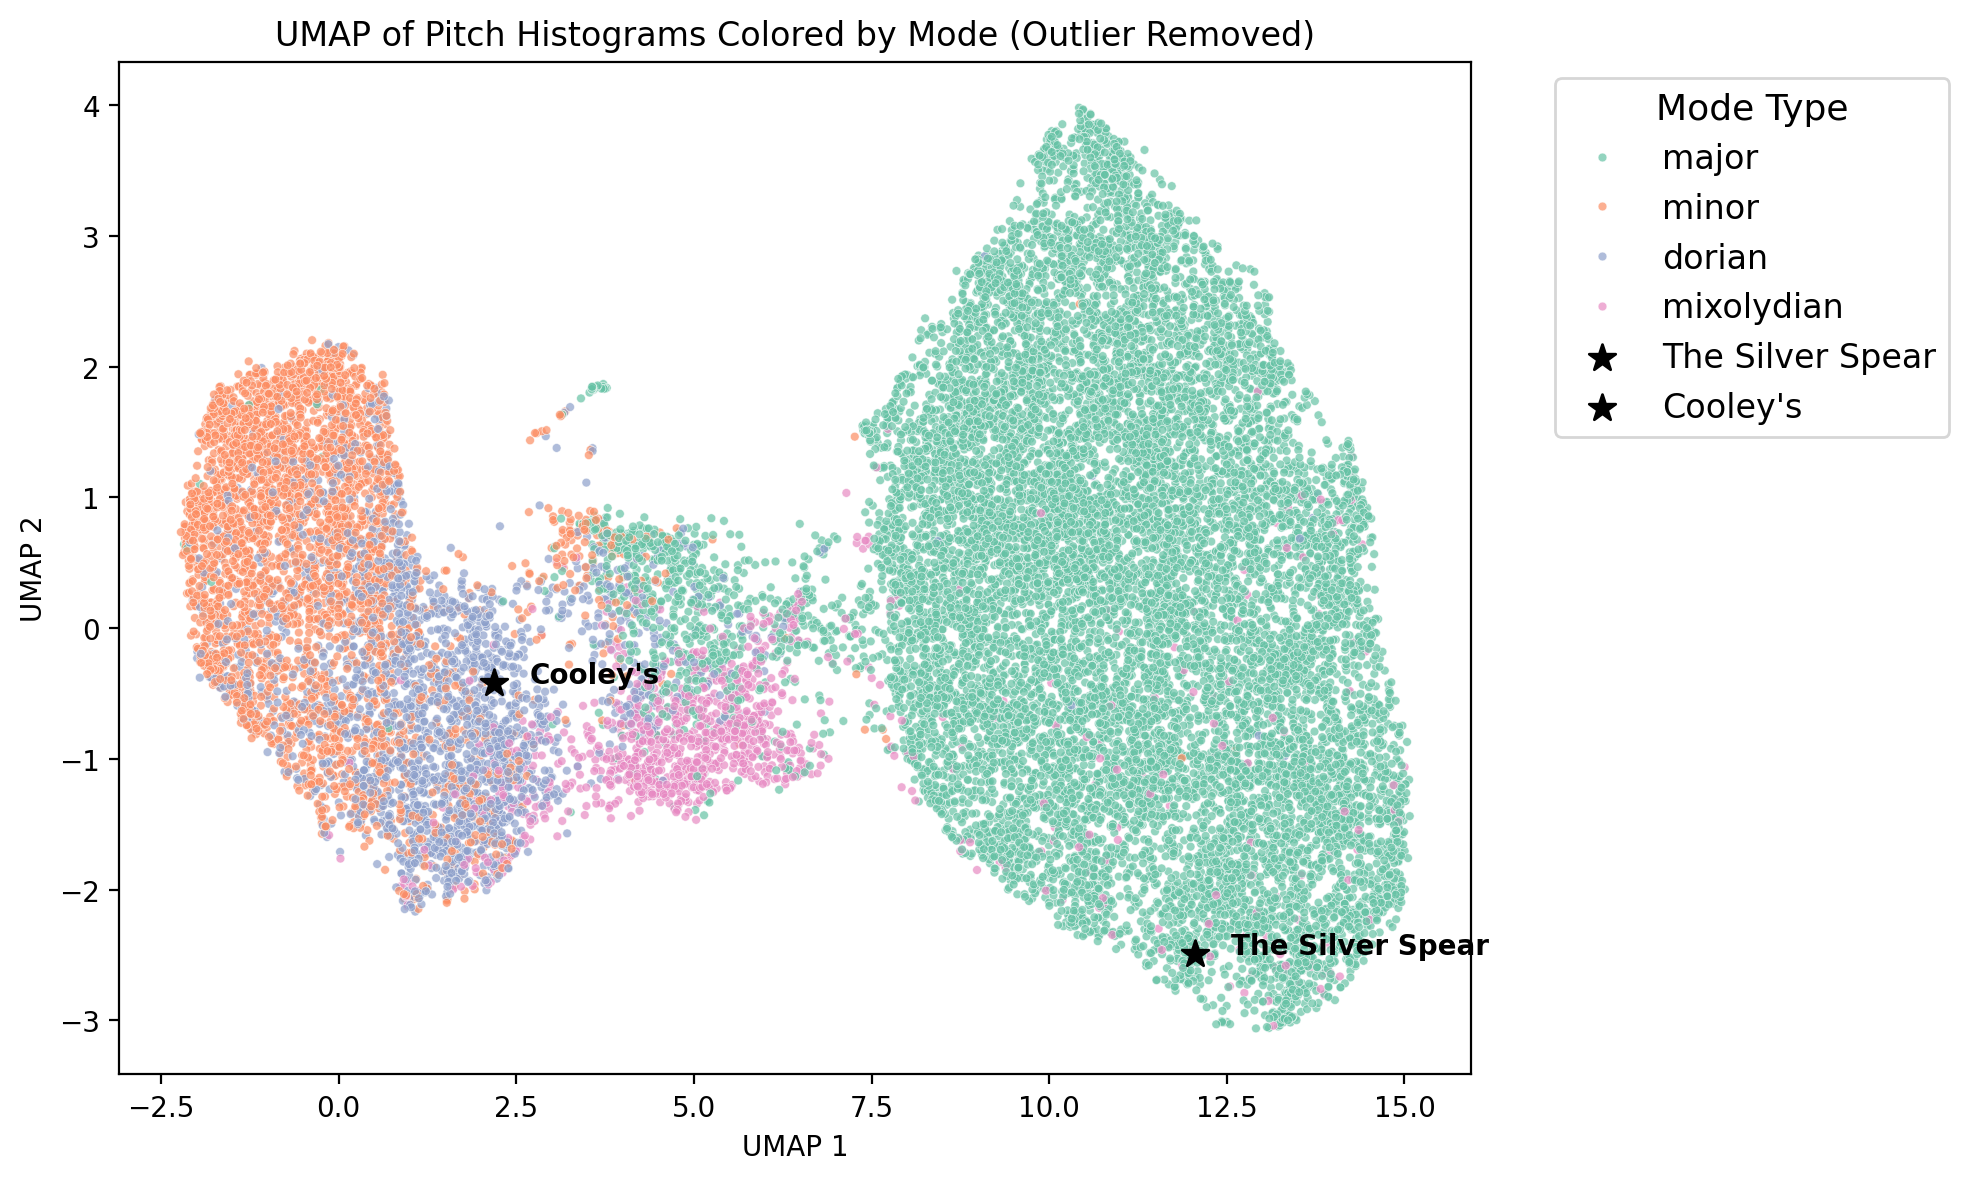

In [10]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
X_umap = umap_model.fit_transform(X)

df_unique["umap1"] = X_umap[:, 0]
df_unique["umap2"] = X_umap[:, 1]
df_plot = df_unique[df_unique["umap2"] < 7].copy()

# Update X_umap and y accordingly
X_umap_filtered = df_plot[["umap1", "umap2"]].values
y_filtered = df_plot["mode_type"].values



# Find the index of the tunes
silver_spear_index = df_unique[df_unique["name"] == "Silver Spear, The"].index
joe_derrane_index = df_unique[df_unique["name"] == "Cooley's"].index

# Print coordinates
if len(silver_spear_index) == 0:
    print("The Silver Spear not found in df_unique.")
else:
    i = silver_spear_index[0]
    x_coord, y_coord = X_umap[i]
    print(f'"The Silver Spear" is at UMAP coordinates: x = {x_coord:.3f}, y = {y_coord:.3f}')

if len(joe_derrane_index) == 0:
    print("Cooley's not found in df_unique.")
else:
    i = joe_derrane_index[0]
    x_coord_2, y_coord_2 = X_umap[i]
    print(f'"Cooleys" is at UMAP coordinates: x = {x_coord_2:.3f}, y = {y_coord_2:.3f}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap_filtered[:, 0], y=X_umap_filtered[:, 1],
                hue=y_filtered, palette="Set2", alpha=0.7, s=10)

# Re-annotate The Silver Spear and Musical Priest
for tune_name, label in [("Silver Spear, The", "The Silver Spear"),
                         ("Cooley's", "Cooley's")]:
    index = df_plot[df_plot["name"] == tune_name].index
    if len(index) > 0:
        i = index[0]
        x, y_coord = df_plot.loc[i, ["umap1", "umap2"]]
        plt.scatter(x, y_coord, color='black', s=100, marker='*', label=label)
        plt.text(x + 0.5, y_coord, label, fontsize=10, weight='bold')

plt.title("UMAP of Pitch Histograms Colored by Mode (Outlier Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Mode Type",
    title_fontsize="13",
    fontsize="12",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()


In [4]:
import json

with open("../data/TheSession-data/json/tune_popularity.json", "r") as f:
    popularity_data = json.load(f)

# Create DataFrame from it
pop_df = pd.DataFrame(popularity_data)

# Make sure tunebook counts are numeric and sort descending
pop_df["tunebooks"] = pd.to_numeric(pop_df["tunebooks"], errors="coerce")
pop_df = pop_df.dropna().sort_values("tunebooks", ascending=False)

# Top 10 most popular tune names
top10_names = pop_df["name"].head(30).tolist()

# Get rows in df_unique matching top 10
top10_df = df_unique[df_unique["name"].isin(top10_names)].copy()

# Get their corresponding t-SNE coordinates
top10_coords = []
for name in top10_df["name"]:
    idx = df_unique[df_unique["name"] == name].index[0]
    x, y_coord = X_umap[idx]
    top10_coords.append((name, x, y_coord))



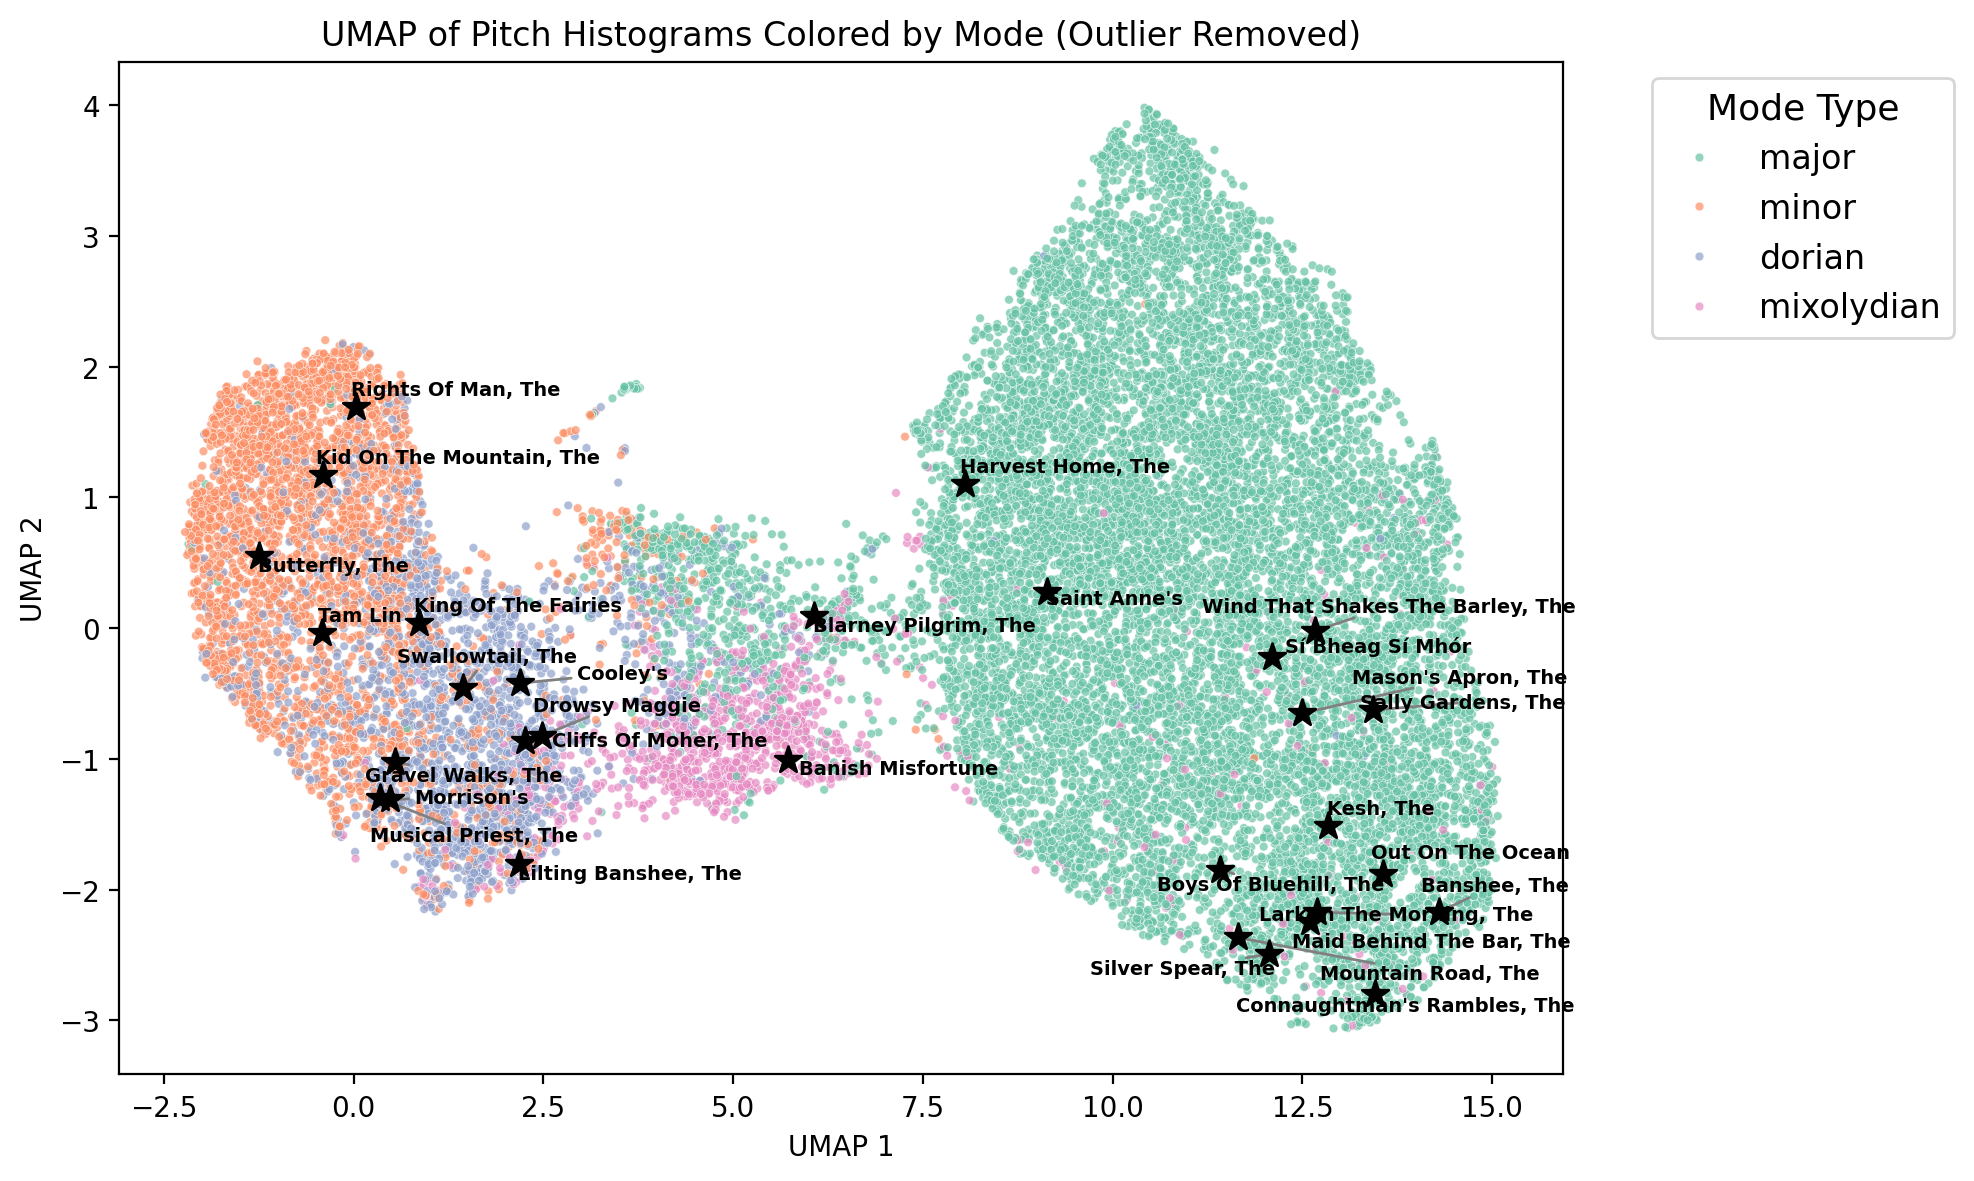

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap_filtered[:, 0], y=X_umap_filtered[:, 1],
                hue=y_filtered, palette="Set2", alpha=0.7, s=10)
# Overlay labeled markers for top 10 tunes
from adjustText import adjust_text

texts = []
for name, x, y_coord in top10_coords:
    plt.scatter(x, y_coord, s=100, c='black', marker='*', zorder=10)
    texts.append(plt.text(x, y_coord, name, fontsize=7, weight='bold', color='black', zorder=11))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))


plt.title("UMAP of Pitch Histograms Colored by Mode (Outlier Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Mode Type",
    title_fontsize="13",
    fontsize="12",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()
